A replication for certain plots/results in R can be found here:
https://christophj.github.io/replicating/r/replicating-goyal-welch-2008/

## Imports

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS

In [3]:
# use notebook working directory; data is in the parent directory
notebook_dir = Path.cwd().parent
file_path_monthly = notebook_dir / "data" / "GW05_original_monthly.csv"
file_path_quarterly = notebook_dir / "data" / "GW05_original_quarterly.csv"
file_path_yearly = notebook_dir / "data" / "GW05_original_annual.csv"
data_monthly = pd.read_csv(file_path_monthly, sep=';', decimal=',')
data_quarterly = pd.read_csv(file_path_quarterly, sep=';', decimal=',')
data_annual = pd.read_csv(file_path_yearly, sep=';', decimal=',')
data_monthly['yyyymm'] = pd.to_datetime(data_monthly['yyyymm'], format='%Y%m')
data_monthly.rename(columns={'yyyymm': 'date'}, inplace=True)
data_annual.set_index('yyyy', inplace=True)


## Replicating annual log equity premium

In [4]:
# create 'missing' columns
data_annual['dp'] = np.log(data_annual["D12"]) - np.log(data_annual["Index"]) # dividend price ratio
data_annual['dy'] = np.log(data_annual["D12"]) - np.log(data_annual["Index"].shift(1)) # dividend yield
data_annual['ep'] = np.log(data_annual["E12"]) - np.log(data_annual["Index"])  # earnings price ratio
data_annual['de'] = np.log(data_annual["D12"]) - np.log(data_annual["E12"]) # dividend payout ratio
data_annual.loc[:, 'equity_premium'] = np.log1p(data_annual['CRSP_SPvw']) - np.log1p(data_annual['Rfree'])

In [5]:
# annual excess return from 1926 to 2005
data_annual['equity_premium'].describe()

count    80.000000
mean      0.060632
std       0.196858
min      -0.621098
25%      -0.050916
50%       0.086896
75%       0.197970
max       0.433438
Name: equity_premium, dtype: float64

These equity premia are close to the ones from Goyal/Welch (2008, p.1457). They differ slightly because I use the updated data from 2024 and some of the values for Rfree and ret were updated (even the values for 1926 were updated, which seems a bit far back). Following Plot is nearly identical to Figure 1 from [GW2003](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=300750).

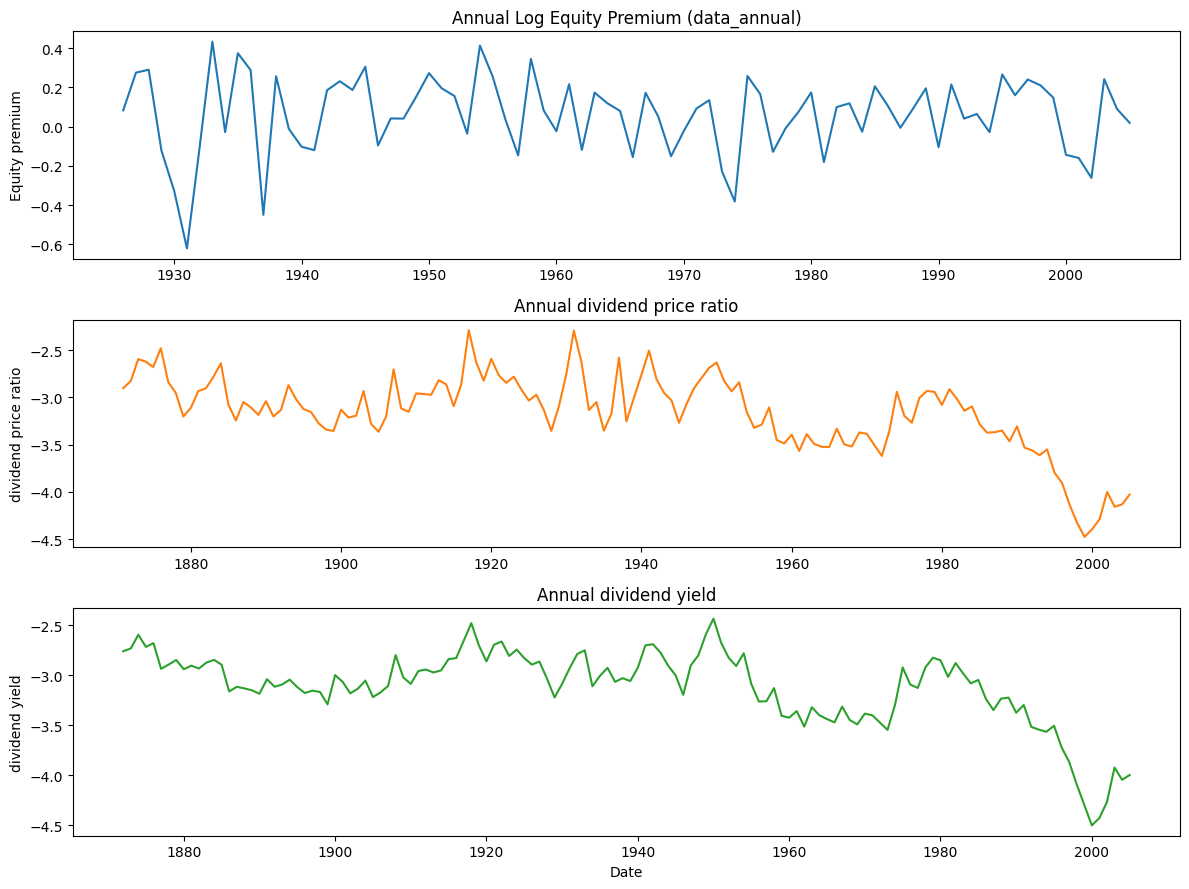

In [6]:
# plot premium over time
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=False)

# top: annual series from data_annual
axes[0].plot(data_annual.index, data_annual['equity_premium'], color='C0')
axes[0].set_title('Annual Log Equity Premium (data_annual)')
axes[0].set_ylabel('Equity premium')

# middle: annual series from computed annual dataframe
axes[1].plot(data_annual.index, data_annual['dp'], color='C1')
axes[1].set_title('Annual dividend price ratio')
axes[1].set_ylabel('dividend price ratio')

# bottom: monthly series (datetime index)
axes[2].plot(data_annual.index, data_annual['dy'], color='C2')
axes[2].set_title('Annual dividend yield')
axes[2].set_ylabel('dividend yield')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

## Getting the statistics for Table 1
Note that I will not use data before 1926 for the equity premium, because returns with dividens only start in 1926 for the uploaded dataset. Plus, the data quality might also be questionable for this early period.

The following is a sample run through the code, I will later just call a function for that to maintain readability for this notebook.

In [7]:
dep = 'equity_premium'
start = 1965; end = 2005
ts_in_sample = data_annual.loc[start:end]
# 1. Historical mean model
avg = ts_in_sample[dep].mean()
IS_error_mean = ts_in_sample[dep] - avg

In [8]:
# 2. OLS model with lagged independent variable
# Create lagged independent variable
indep = 'ntis'
lagged_indep = ts_in_sample[indep].shift(1)
# Drop NA values due to lag
valid_idx = lagged_indep.dropna().index
y = ts_in_sample.loc[valid_idx, dep]
X = lagged_indep.loc[valid_idx]
X_const = add_constant(X)
reg = OLS(y, X_const).fit()
IS_error_cond = reg.resid

In [9]:
IS_R2 = reg.rsquared
IS_R2_head = IS_R2 - (1 - IS_R2)*(len(IS_error_cond)-int(reg.df_resid))/(len(IS_error_cond)-1)

In [10]:
round(IS_R2_head*100, 2)

np.float64(-1.17)

The 8.57% is close to the 8.15% in the paper.

In [11]:
# OOS ANALYSIS
est_periods_OOS = 20
OOS_error_M = []
OOS_error_C = []
for i in range(start + est_periods_OOS, end):
    # Actual Equity Risk Premium (ERP) at time i+1
    actual_ERP = data_annual.loc[i+1, dep]
    # Historical mean model forecast using data up to i
    avg_i = data_annual.loc[start:i, dep].mean()
    OOS_error_M.append(actual_ERP - avg_i)

    # OLS model forecast using data up to i
    ts_train = data_annual.loc[start:i]
    lagged_indep_train = ts_train[indep].shift(1)
    valid_idx_train = lagged_indep_train.dropna().index
    y_train = ts_train.loc[valid_idx_train, dep]
    X_train = lagged_indep_train.loc[valid_idx_train]
    X_train_const = add_constant(X_train)
    reg_OOS = OLS(y_train, X_train_const).fit()

    # Prepare new data for prediction (lagged independent variable at time i)
    x_new = data_annual.loc[i, indep]
    x_new_df = pd.DataFrame({indep: [x_new]})
    x_new_const = add_constant(x_new_df, has_constant='add')
    pred_ERP = reg_OOS.predict(x_new_const)[0]
    OOS_error_C.append(pred_ERP - actual_ERP)

In [12]:
MSE_M = np.mean(np.array(OOS_error_M)**2)
MSE_C = np.mean(np.array(OOS_error_C)**2)
OOS_R2 = 1 - (MSE_C / MSE_M)
T = len(valid_idx_train)
k = T - 1
OOS_R2_head = OOS_R2 - (1-OOS_R2)*(T-k)/(T-1)
print(f"OOS R^2: {OOS_R2_head*100}")
dRMSE = np.sqrt(MSE_M) - np.sqrt(MSE_C)
print(f"dRMSE: {dRMSE*100}")

OOS R^2: -20.20499651179567
dRMSE: -1.262144807622556


## Replicating plots from Goyal/Welch (2008)
 Null hypothesis is that unconditional forecast is not inferior to conditional forecast. Therefore, critical values for OOS are for one-sided test. Critical values for IS are based on two-sided tests. They make annual predictions and have 3 specifications for the timeline. First, OOS Forecast begins after 20 years of data availability. Second starts OOS Forecast in 1965. Third, ignore all data before 1927, even for estimation.

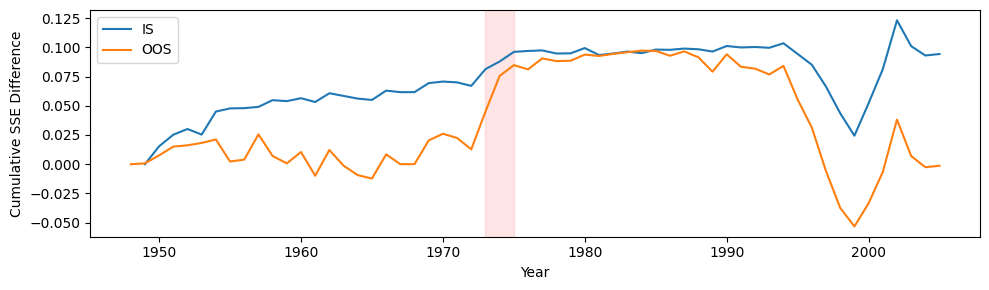

In [13]:
from helper import get_statistics as help_get_stat
dp = help_get_stat(data_annual, indep='dp', dep='equity_premium', start=1927, end=2005, plot='yes')

For interpretation see GW2008: "These figures plot the IS and OOS performance of annual predictive regressions. Specifically,
these are the cumulative squared prediction errors of the NULL minus the cumulative squared prediction
error of the ALTERNATIVE. The ALTERNATIVE is a model that relies on predictive variables noted
in each graph. The NULL is the prevailing equity premium mean for the OOS graph, and the full-period
equity premium mean for the IS graph. The IS prediction relative performance is dotted (and usually
above), the OOS prediction relative perfomance is solid. An increase in a line indicates better performance
of the named model; a decrease in a line indicates better performance of the NULL. The blue band is the
equivalent of 95% two-sided levels, based on MSE-T critical values from McCracken (2004). (MSE-T is
the Diebold and Mariano (1995)
t-statistic modified by Harvey, Leybourne, and Newbold (1998)). The
right axis shifts the zero point to 1965. The Oil Shock is marked by a red vertical line."

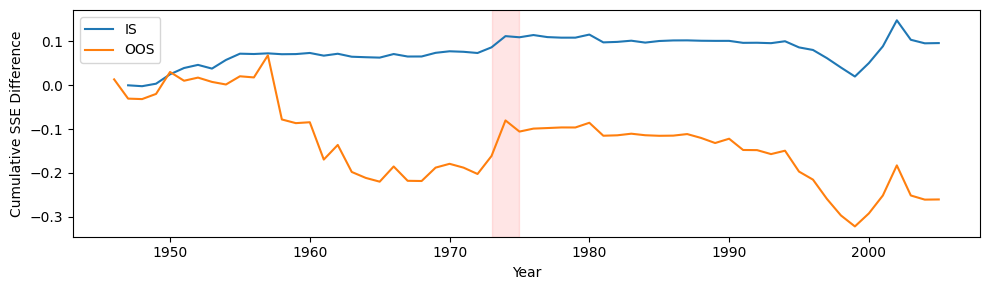

In [14]:
dy = help_get_stat(data_annual, indep='dy', dep='equity_premium', start=1925, end=2005, plot='yes')

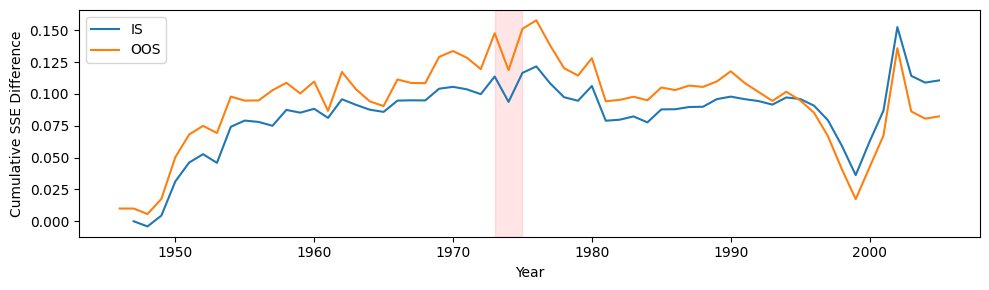

In [15]:
ep = help_get_stat(data_annual, indep='ep', dep='equity_premium', start=1925, end=2005, plot='yes')

In [16]:
eqis = help_get_stat(data_annual, indep='eqis', dep='equity_premium', start=1927, end=2005)
eqis

{'IS_R2_head_1927': 8.46,
 'IS_R2_head_OOS': 1.44,
 'IS_R2_head_1965': 1.54,
 'OOS_oR2': 1.93,
 'dRMSE': 0.26,
 'MSEf': 2.6}

In [23]:
bm = help_get_stat(data_annual, indep='b/m', dep='equity_premium', start=1927, end=2005)
bm

{'IS_R2_head_1927': 2.97,
 'IS_R2_head_OOS': -1.27,
 'IS_R2_head_1965': -4.75,
 'OOS_oR2': -13.48,
 'dRMSE': -0.95,
 'MSEf': -8.61}

In [25]:
ntis = help_get_stat(data_annual, indep='ntis', dep='equity_premium', start=1927, end=2005)
ntis

{'IS_R2_head_1927': 8.57,
 'IS_R2_head_OOS': -3.17,
 'IS_R2_head_1965': -1.17,
 'OOS_oR2': -5.54,
 'dRMSE': -0.34,
 'MSEf': -3.24}

In [28]:
ik = help_get_stat(data_annual, indep='ik', dep='equity_premium', start=1947, end=2005)
ik

{'IS_R2_head_1927': 4.93,
 'IS_R2_head_OOS': -0.66,
 'IS_R2_head_1965': -0.46,
 'OOS_oR2': 3.59,
 'dRMSE': 0.4,
 'MSEf': 4.03}

To summarize: It's a mess. Since i do not have data starting from 1871, the first forecast is always off, but actually still close to reported results. The forecasts starting 1965 and 1927 should be reproducible, but although here the results seem roughly similar, no exact reproduction was possible. What exactly is k and T? 
As I will not use annual data, I just blame the authors for putting together such a confusing dataset and hope the monthly data will be more useful.

# Monthly Data

In [17]:
print(data_monthly.head())
print(data_monthly.shape)

        date  Index   D12  E12  b/m  tbl  AAA  BAA  lty  ntis     Rfree  infl  \
0 1871-01-01   4.44  0.26  0.4  NaN  NaN  NaN  NaN  NaN   NaN  0.004955   NaN   
1 1871-02-01   4.50  0.26  0.4  NaN  NaN  NaN  NaN  NaN   NaN  0.004514   NaN   
2 1871-03-01   4.61  0.26  0.4  NaN  NaN  NaN  NaN  NaN   NaN  0.004243   NaN   
3 1871-04-01   4.74  0.26  0.4  NaN  NaN  NaN  NaN  NaN   NaN  0.004632   NaN   
4 1871-05-01   4.86  0.26  0.4  NaN  NaN  NaN  NaN  NaN   NaN  0.003691   NaN   

   ltr  corpr  svar  csp  CRSP_SPvw  CRSP_SPvwx  
0  NaN    NaN   NaN  NaN        NaN         NaN  
1  NaN    NaN   NaN  NaN        NaN         NaN  
2  NaN    NaN   NaN  NaN        NaN         NaN  
3  NaN    NaN   NaN  NaN        NaN         NaN  
4  NaN    NaN   NaN  NaN        NaN         NaN  
(1620, 18)


In [18]:
# show columns with only nan values
nan_columns = data_monthly.columns[data_monthly.isna().all()].tolist()
print("Columns with only NaN values:", nan_columns)
# delete these columns
data_monthly.drop(columns=nan_columns, inplace=True)
print("Shape after dropping NaN columns:", data_monthly.shape)

Columns with only NaN values: []
Shape after dropping NaN columns: (1620, 18)


In [19]:
data_monthly.describe()

,date,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
count,1620,1620.000000,1620.000000,1620.000000,1018.000000,1031.000000,1044.000000,1044.000000,1044.000000,949.000000,1620.000000,1115.000000,960.000000,960.000000,1451.000000,788.000000,960.000000,960.000000
mean,1938-06-16 19:12:00,135.360574,3.212263,6.989980,0.601192,0.037686,0.059310,0.071235,0.052844,0.021265,0.003228,0.002690,0.004695,0.005008,0.002413,0.000364,0.009675,0.006271
min,1871-01-01 00:00:00,2.730000,0.180000,0.160000,0.120510,0.000100,0.024600,0.029400,0.018200,-0.034357,0.000008,-0.032088,-0.098200,-0.089000,0.000000,-0.004166,-0.287300,-0.291300
25%,1904-09-23 12:00:00,7.165000,0.333300,0.490000,0.443374,0.011750,0.036075,0.048600,0.030250,0.010003,0.002015,0.000000,-0.006200,-0.003025,0.000729,-0.001594,-0.017425,-0.020100
50%,1938-06-16 00:00:00,13.340000,0.686700,1.120500,0.578936,0.033900,0.051150,0.067850,0.043850,0.019855,0.003118,0.002418,0.003200,0.004000,0.001225,-0.000284,0.012800,0.008750
75%,1972-03-08 18:00:00,95.542500,3.160825,5.877475,0.762812,0.053750,0.076800,0.086550,0.070125,0.028845,0.004125,0.005256,0.014500,0.012700,0.002187,0.002296,0.039800,0.036500
max,2005-12-01 00:00:00,1517.680000,22.220000,69.930000,2.028478,0.163000,0.154900,0.171800,0.148200,0.175604,0.013492,0.057357,0.152300,0.137600,0.070945,0.007688,0.416500,0.414500
std,NaN,293.403581,4.890944,12.227101,0.256364,0.029934,0.028041,0.029607,0.027745,0.023209,0.002100,0.006484,0.022728,0.019993,0.004630,0.002375,0.056043,0.056125


For a description of each of the variables, see data/GW2024_info.md

In [20]:
# plot every variable over time in a grid
# import matplotlib.pyplot as plt
# num_vars = data_monthly.shape[1] - 1  # exclude date column
# num_cols = 4
# num_rows = (num_vars + num_cols - 1) // num_cols
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
# for i, column in enumerate(data_monthly.columns[1:]):  # exclude date column
#     ax = axes[i // num_cols, i % num_cols]
#     ax.plot(data_monthly['date'], data_monthly[column])
#     ax.set_title(column)
#     ax.set_xlabel('Date')
#     ax.set_ylabel(column)
# plt.tight_layout()
# plt.show()

The variable to be forecasted is: "log equity premiums using CRSP’s definition of the S&P 500 including
dividends net of the (Ken French posted) Treasury return in nonoverlapping
periods at their native frequencies" (GWZ24). In the data this should be Rfree (for riskfree return) and ret (return w/ dividends). A Rfree of 0.0049 means 0.49% return over a month with riskfree rate (annualized this would be > 5%).

In [21]:
data_monthly['log_equity_premium'] = np.log1p(data_monthly['ret']) - np.log1p(data_monthly['Rfree'])

KeyError: 'ret'

In [ ]:
data_monthly["log_equity_premium"].describe()

count    1188.000000
mean        0.005466
std         0.053750
min        -0.339221
25%        -0.019978
50%         0.010113
75%         0.035221
max         0.345644
Name: log_equity_premium, dtype: float64

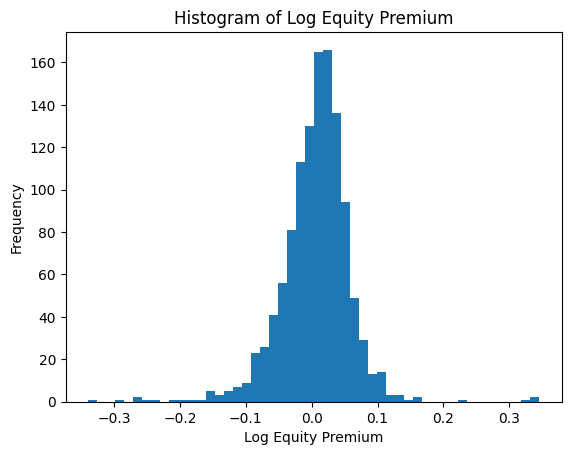

In [ ]:
# plot histogram of excess returns
plt.hist(data_monthly["log_equity_premium"].dropna(), bins=50)
plt.title("Histogram of Log Equity Premium")
plt.xlabel("Log Equity Premium")
plt.ylabel("Frequency")
plt.show()

In [ ]:
data_monthly.set_index('date', inplace=True)

In [ ]:
model = linear_regression(data_monthly[['tail']], data_monthly['log_equity_premium'], '1963-01', '2010-12')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_equity_premium   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.225
Date:                Wed, 29 Oct 2025   Prob (F-statistic):              0.136
Time:                        17:36:25   Log-Likelihood:                 985.55
No. Observations:                 576   AIC:                            -1967.
Df Residuals:                     574   BIC:                            -1958.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0220      0.017     -1.279      0.2